# Siddon's Algorithm for Ray Tracing 
Here I will be attempting to implement my own version of Siddon's Algorithm. Very much an attempt.

### THE ALGORITHM
- Calculate range of parametric values $(\alpha_{min},\alpha_{max})$
- Calculate range of indices $(i_{min},i_{max}),(j_{min},j_{max}),(k_{min},k_{max})$
- Calculate parametric sets $\{\alpha_x\},\{\alpha_y\},\{\alpha_z\}$
- Merge sets to form set $\{\alpha\}$
- Calculate voxel lengths
- Calculate voxel indices

In [21]:
%pylab ipympl
from scipy import interpolate

Populating the interactive namespace from numpy and matplotlib


#### Calculate Range of Parametric Values

In [2]:
def alpha_func(plane,coor1,coor2):
    '''
    plane is assumed to be already calculated
    '''
    return (plane-coor1)/(coor2-coor1)

In [3]:
def plane_func(index,plane1,d):
    '''
    Parameters:
    ----------
    index :: integer
      index to evaluate at, index in (1,...,n)
    
    plane1 :: float 
      location of plane with index 1 
    
    d :: float 
      distance between planes
    
    Returns:
    -------
    plane_location :: float 
      the location of the plane of the specified index
    
    '''
    return plane1 + (index-1)*d

In [4]:
def voxel_length(alpha,index,d12):
    '''
    Parameters:
    ----------
    alpha :: list
      list of alpha values
    
    index :: integer
      index to evaluate at, index in (1,...,n)
    
    d12 :: float
      distance from point one to point two
    
    Returns:
    -------
    voxel_length :: float
      voxel intersection length
      
    '''
    
    return d12*(alpha[index]-alpha[index-1])

In [5]:
def voxel_indices(plane1s,coor1s,coor2s,distances,alpha,index):
    '''
    Parameters:
    ----------
    plane1s :: array
      coordinate plane (1) in form (x,y,z)
    
    coor1s :: array
      coordinate one in form (x,y,z)
    
    coor2s :: float
      coordinate two in form (x,y,z)
    
    distances :: float
      distance between two planes in form (x,y,z)
      
    alpha :: array
      ordered set of alpha values
    
    index :: integer
      i in 1,...,nfinal
    
    Returns:
    -------
    voxel_index :: integer
      voxel index for the specific coordinate 
    
    '''
    a_mid = alpha_mid(alpha,index)
    
    i = int(np.floor(1 + (coor1s[0] + a_mid*(coor2s[0]-coor1s[0])-plane1s[0])/distances[0]))
    j = int(np.floor(1 + (coor1s[1] + a_mid*(coor2s[1]-coor1s[1])-plane1s[1])/distances[1]))
    k = int(np.floor(1 + (coor1s[2] + a_mid*(coor2s[2]-coor1s[2])-plane1s[2])/distances[2]))
    
    return (i,j,k)

In [6]:
def alpha_mid(alpha,index):
    '''
    Parameters:
    ----------
    alpha :: array
      ordered set of alpha values
    
    index :: integer
      i in 1,...,nfinal
    
    Returns:
    -------
    alpha_mid :: float 
    
    '''
    return (alpha[index]+alpha[index-1])/2

In [51]:
# IMPROVE LATER ONCE I ACTUALLY HAVE INFORMATION ABOUT HOW I WILL GET DENSITY
def density(voxel_index):
    '''
    Parameters:
    ----------
    voxel_index :: tuple (3)
      the index of the voxel 
    '''
    
    return 1

In [7]:
'''
Parameters
'''
# for a CT array of (Nx-1,Ny-1,Nz-1) voxels
Nx = 5 
Ny = 4
Nz = 4

# distances between the x,y,z planes (also the lengths of the sides of the voxels) 
# ALL HAS TO BE IN CM
dx = 0.1
dy = 2
dz = 0.5

# initial and final coordinates of the beam
x1,x2 = (0.5,0)
y1,y2 = (3,0)
z1,z2 = (2,0.25)

# initial plane coordinates
xplane1 = 0
yplane1 = 0
zplane1 = 0

'''
Setting up Dictionary 
'''
# MAKE A DESCRIPTION OF EACH OF THE QUANTITIES OF THE DICTIONARY

coor_values = {'x':{},'y':{},'z':{}}

coor_values['x']['N'] = Nx
coor_values['y']['N'] = Ny
coor_values['z']['N'] = Nz

coor_values['x']['d'] = dx
coor_values['y']['d'] = dy
coor_values['z']['d'] = dz

coor_values['x']['1,2'] = (x1,x2)
coor_values['y']['1,2'] = (y1,y2)
coor_values['z']['1,2'] = (z1,z2)

coor_values['x']['plane'] = [xplane1] # this ends up being min,max
coor_values['y']['plane'] = [yplane1]
coor_values['z']['plane'] = [zplane1]

for key in coor_values.keys():
    coor_values[key]['plane'].append(plane_func(coor_values[key]['N'],coor_values[key]['plane'][0],coor_values[key]['d']))

for key in coor_values.keys():
    if coor_values[key]['1,2'][1] - coor_values[key]['1,2'][0] != 0:
        coor_values[key]['alpha_minmax'] = (alpha_func(coor_values[key]['plane'][0],coor_values[key]['1,2'][0],coor_values[key]['1,2'][1]),alpha_func(coor_values[key]['plane'][-1],coor_values[key]['1,2'][0],coor_values[key]['1,2'][1]))
    else:
        coor_values[key]['alpha_minmax'] = (0,1) # set to this so that it doesn't affect later business

alpha_min = max(0,min(coor_values['x']['alpha_minmax']),min(coor_values['y']['alpha_minmax']),min(coor_values['z']['alpha_minmax']))
alpha_max = min(1,max(coor_values['x']['alpha_minmax']),max(coor_values['y']['alpha_minmax']),max(coor_values['z']['alpha_minmax']))

print(alpha_min,alpha_max)


0.2857142857142857 1


#### Calculate Range of Indices

In [8]:
# FOR SOME REASON IT WORKS IF I ROUND THE INDICES BUT I DON'T LIKE THAT 

for key in coor_values.keys():
    if coor_values[key]['1,2'][1] - coor_values[key]['1,2'][0] >= 0:
        indmin = coor_values[key]['N'] - (coor_values[key]['plane'][-1]-alpha_min*(coor_values[key]['1,2'][1] - coor_values[key]['1,2'][0])-coor_values[key]['1,2'][0])/coor_values[key]['d']
        indmax = 1 - (coor_values[key]['plane'][0]-alpha_max*(coor_values[key]['1,2'][1] - coor_values[key]['1,2'][0])-coor_values[key]['1,2'][0])/coor_values[key]['d']
        indmin = int(ceil(indmin))
        indmax = int(floor(indmax))
        coor_values[key]['indminmax'] = (indmin,indmax)
    else:
        indmin = coor_values[key]['N'] - (coor_values[key]['plane'][-1]-alpha_max*(coor_values[key]['1,2'][1] - coor_values[key]['1,2'][0])-coor_values[key]['1,2'][0])/coor_values[key]['d']
        indmax = 1 - (coor_values[key]['plane'][0]-alpha_min*(coor_values[key]['1,2'][1] - coor_values[key]['1,2'][0])-coor_values[key]['1,2'][0])/coor_values[key]['d']
        indmin = int(ceil(indmin))
        indmax = int(floor(indmax))
        coor_values[key]['indminmax'] = (indmin,indmax)

print(coor_values['x']['indminmax'])
print(coor_values['y']['indminmax'])
print(coor_values['z']['indminmax'])


(1, 4)
(1, 2)
(2, 4)


#### Calculate Parametric Sets

In [9]:
alpha_coor_set = {}

for key in coor_values.keys():
    if coor_values[key]['1,2'][1] - coor_values[key]['1,2'][0] > 0:
        print(array([n for n in range(coor_values[key]['indminmax'][0],coor_values[key]['indminmax'][1]+1)]))
        coor_values[key]['alpha_set'] = alpha_func(plane_func(array([n for n in range(coor_values[key]['indminmax'][0],coor_values[key]['indminmax'][1]+1)]),coor_values[key]['plane'][0],coor_values[key]['d']),coor_values[key]['1,2'][0],coor_values[key]['1,2'][1])
    elif coor_values[key]['1,2'][1] - coor_values[key]['1,2'][0] < 0:
        print(array([n for n in range(coor_values[key]['indminmax'][1],coor_values[key]['indminmax'][0]-1,-1)]))
        coor_values[key]['alpha_set'] = alpha_func(plane_func(array([n for n in range(coor_values[key]['indminmax'][1],coor_values[key]['indminmax'][0]-1,-1)]),coor_values[key]['plane'][0],coor_values[key]['d']),coor_values[key]['1,2'][0],coor_values[key]['1,2'][1])
    else:
        coor_values[key]['alpha_set'] = []
    print(coor_values[key]['alpha_set'])


[4 3 2 1]
[0.4 0.6 0.8 1. ]
[2 1]
[0.33333333 1.        ]
[4 3 2]
[0.28571429 0.57142857 0.85714286]


#### Merge Sets to Form Alpha Set

In [10]:
alpha = [alpha_min,alpha_max] + list(coor_values['x']['alpha_set']) + list(coor_values['y']['alpha_set']) + list(coor_values['z']['alpha_set'])
alpha = sort(list(alpha))
alpha


array([0.28571429, 0.28571429, 0.33333333, 0.4       , 0.57142857,
       0.6       , 0.8       , 0.85714286, 1.        , 1.        ,
       1.        ])

#### Calculate Voxel Lengths

In [11]:
nfinal = 1
d12 = 0
for key in coor_values.keys():
    if coor_values[key]['1,2'][1] - coor_values[key]['1,2'][0] != 0:
        nfinal += coor_values[key]['indminmax'][1] - coor_values[key]['indminmax'][0] + 1 
    d12 += (coor_values[key]['1,2'][1] - coor_values[key]['1,2'][0])**2
d12 = sqrt(d12)

print(d12,nfinal)

3.5089172119045497 10


#### Calculate Voxel Indices

In [49]:
# print(coor_values['x']['plane'][0],coor_values['y']['plane'][0],coor_values['z']['plane'][0])
# print(coor_values['x']['1,2'][0],coor_values['y']['1,2'][0],coor_values['z']['1,2'][0])
# print(coor_values['x']['1,2'][1],coor_values['y']['1,2'][1],coor_values['z']['1,2'][1])
# print(coor_values['x']['d'],coor_values['y']['d'],coor_values['z']['d'])

# UNSURE ABOUT INDICES
# using floor to get voxel index
# make a note of what it does in boundary cases 

voxel_info = []

for i in range(1,nfinal+1):
    length = voxel_length(alpha,i,d12)
    indices = voxel_indices((coor_values['x']['plane'][0],coor_values['y']['plane'][0],coor_values['z']['plane'][0]),(coor_values['x']['1,2'][0],coor_values['y']['1,2'][0],coor_values['z']['1,2'][0]),(coor_values['x']['1,2'][1],coor_values['y']['1,2'][1],coor_values['z']['1,2'][1]),(coor_values['x']['d'],coor_values['y']['d'],coor_values['z']['d']),alpha,i)
    voxel_info.append({})
    voxel_info[i-1]['d'] = length
    voxel_info[i-1]['indices'] = indices

voxel_info

[{'d': 0.0, 'indices': (4, 2, 4)},
 {'d': 0.16709129580497856, 'indices': (4, 2, 3)},
 {'d': 0.23392781412696972, 'indices': (4, 1, 3)},
 {'d': 0.601528664897923, 'indices': (3, 1, 3)},
 {'d': 0.10025477748298717, 'indices': (3, 1, 2)},
 {'d': 0.7017834423809102, 'indices': (2, 1, 2)},
 {'d': 0.20050955496597395, 'indices': (1, 1, 2)},
 {'d': 0.5012738874149358, 'indices': (1, 1, 1)},
 {'d': 0.0, 'indices': (1, 1, 1)},
 {'d': 0.0, 'indices': (1, 1, 1)}]

## Sum it all up 
Here I must diverge from the paper; this is where the superposition/convolution algorithm goes. (Sorta)

## Attempting to Calculate TERMA

In [57]:
'''
Parameters
'''
ini_energy = 0.120 # in MeV
filename = 'energy_absorption_coeff.txt'

'''
Code
'''
coeff_array = np.loadtxt(filename,skiprows=2,dtype=float)

e_a_coeffs = [] # energy absorption coefficients

for row in coeff_array:
    e_a_coeffs.append([row[0],row[1]])

e_a_coeffs = np.array(e_a_coeffs)

mu_energy = interpolate.interp1d(e_a_coeffs.T[0],e_a_coeffs.T[1],kind='nearest',fill_value='extrapolate')
mu = lambda energy, material: mu_energy(energy) # CHANGE THIS LATER TO A REAL FUNCTION

In [43]:
e_a_coeffs

array([[5.000e-03, 4.259e+01],
       [6.000e-03, 2.464e+01],
       [8.000e-03, 1.037e+01],
       [1.000e-02, 5.330e+00],
       [1.500e-02, 1.672e+00],
       [2.000e-02, 8.098e-01],
       [3.000e-02, 3.756e-01],
       [4.000e-02, 2.683e-01],
       [5.000e-02, 2.269e-01],
       [6.000e-02, 2.059e-01],
       [8.000e-02, 1.837e-01],
       [1.000e-01, 1.707e-01],
       [1.500e-01, 1.505e-01],
       [2.000e-01, 1.370e-01]])

In [58]:
# THIS ONLY WORKS FOR WATER!!! MAKE SURE YOU ADD IN DENSITY BUSINESS
# THE MU IS ALSO ONLY CALCULATED FOR WATER... will need to figure out how to get for different materials later 
fraction = 1
for index in range(len(voxel_info)):
    fraction_lost = fraction - fraction*np.exp(-mu(ini_energy,voxel_info[index]['indices'])*voxel_info[index]['d'])
    voxel_info[index]['fraction_lost'] = fraction_lost
    fraction = fraction - fraction_lost

voxel_info

[{'d': 0.0, 'indices': (4, 2, 4), 'energy_lost': 0.0, 'fraction_lost': 0.0},
 {'d': 0.16709129580497856,
  'indices': (4, 2, 3),
  'energy_lost': 0.003374346965740932,
  'fraction_lost': 0.028119558047841053},
 {'d': 0.23392781412696972,
  'indices': (4, 1, 3),
  'energy_lost': 0.004565278912413109,
  'fraction_lost': 0.03804399093677591},
 {'d': 0.601528664897923,
  'indices': (3, 1, 3),
  'energy_lost': 0.010935428502818312,
  'fraction_lost': 0.09112857085681925},
 {'d': 0.10025477748298717,
  'indices': (3, 1, 2),
  'energy_lost': 0.0017158766014276766,
  'fraction_lost': 0.014298971678563976},
 {'d': 0.7017834423809102,
  'indices': (2, 1, 2),
  'energy_lost': 0.011223007884153813,
  'fraction_lost': 0.09352506570128183},
 {'d': 0.20050955496597395,
  'indices': (1, 1, 2),
  'energy_lost': 0.0031891166797534953,
  'fraction_lost': 0.024727271497377634},
 {'d': 0.5012738874149358,
  'indices': (1, 1, 1),
  'energy_lost': 0.00747730666195065,
  'fraction_lost': 0.05823907395730721},

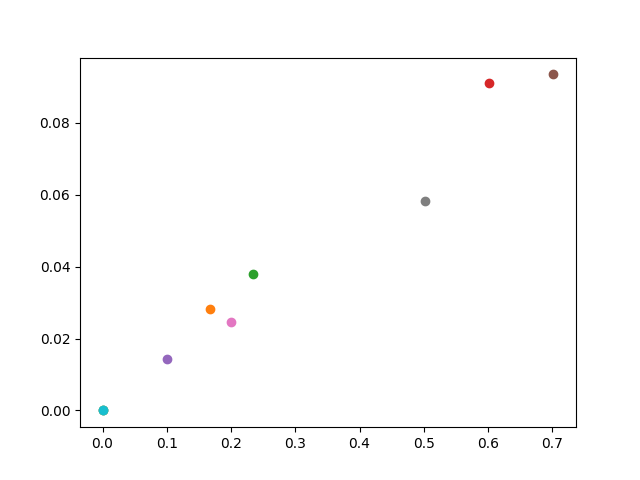

In [61]:
close(1);figure(1)
for index in range(len(voxel_info)):
    plot(voxel_info[index]['d'],voxel_info[index]['fraction_lost'],'o')